In [1]:
import numpy as np
import pandas as pd 
import lightgbm as lgb
import gc
from fastai.tabular import *
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import KFold, StratifiedKFold
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import datetime
from tqdm import tqdm_notebook

In [2]:
def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

In [3]:
train = pd.read_csv('/kaggle/input/zindi-weekendz-pollution/Train.csv')
test = pd.read_csv('/kaggle/input/zindi-weekendz-pollution/Test.csv')
sample_sub = pd.read_csv('/kaggle/input/zindi-weekendz-pollution/SampleSubmission.csv')

### Converting to datetime to use date features.

In [4]:
train['Date'] = pd.to_datetime(train['Date'], format='%Y-%m-%d')
test['Date'] = pd.to_datetime(test['Date'], format='%Y-%m-%d')

In [5]:
ID_COL, TARGET_COL = 'Place_ID X Date', 'target'
df = pd.concat([train, test]).reset_index(drop=True)
features = [c for c in df.columns if c not in ['Date', 'target_count', 'target_min', 'Place_ID X Date', 'target_variance', 'Place_ID', 'target_max', 'target']]


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


## Feature Engineering

### Frequency Encoding

We cannot use the PlaceID directly since its different for both train and test data, but we can use the the number of times each place appears in the dataframe is not same for every place.

In [6]:
df['placeID_freq'] = df['Place_ID'].map(df['Place_ID'].value_counts())

### Time Series Features

### A. Using Previous and Future Target Values.

Pollution levels yesterday could tell about the pollution levels today, similary pollution levels tomorrow, could also tell about pollution levels today. We add this information to our dataset, using shift and expanding functions

In [7]:
for i in range(1, 20):
    df[f'prev_target_{i}'] = df.sort_values(by='Date')[TARGET_COL].fillna(method='ffill').shift(i).sort_index()
    df[f'next_target_{i}'] = df.sort_values(by='Date')[TARGET_COL].fillna(method='bfill').shift(-i).sort_index()

In [8]:
for i in tqdm_notebook(range(1, 15)):
    df[f'magic_{i}'] = df.sort_values(by='Date')[TARGET_COL].shift(i).expanding().mean().fillna(method='ffill').sort_index()
    df[f'magic2_{i}'] = df.sort_values(by='Date')[TARGET_COL].shift(-i).expanding().mean().fillna(method='bfill').sort_index()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


### B. Cyclic Components

Date has cyclic components, for example monday repeats after every 7 days, adding this as a feature can help capture more information from the dataset.

To read more visit:

https://docs.fast.ai/tabular.transform.html#add_cyclic_datepart

In [9]:
for i in tqdm_notebook(range(1, 45)):
    c = 'Date' + str(i+1)
    df[c] = df['Date']  + datetime.timedelta(days=i)
    _ = add_cyclic_datepart(df, c, prefix = c)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


### C. Sensor Readings of previous and future days.

Similar to the pollution readings of previous and future days, we can utilize the sensor readings of previous and future days too, to help predict the pollution for today, also the difference between the sensor readings today and sensor readings from the past and future can help. I added 10 days worth of this information to the dataset, you are free to experiment with more or lesser number of days

In [10]:

    
for i in tqdm_notebook(range(1, 11)):
    tmp = df.sort_values(by='Date').groupby('Place_ID')[features].shift(i).sort_index()
    tmp_diff_prev = df[features] - tmp
    tmp.columns = [c + f'_prev_{i}' for c in tmp.columns]
    tmp_diff_prev.columns = [c + f'_prev_diff_{i}' for c in tmp_diff_prev.columns]
    df = pd.concat([df, tmp, tmp_diff_prev], axis=1)
    
    tmp = df.sort_values(by='Date').groupby('Place_ID')[features].shift(-i).sort_index()
    tmp_diff_next = df[features] - tmp
    tmp.columns = [c + f'_next_{i}' for c in tmp.columns]
    tmp_diff_next.columns = [c + f'_next_diff_{i}' for c in tmp_diff_next.columns]
    df = pd.concat([df, tmp, tmp_diff_next], axis=1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


### D. Using simple features extracted from the date itself.
Like dayofweek, weekend or not, month, days_in_month, etc.

In [11]:
for attr in ['day', 'month', 'week', 'dayofweek', 'weekofyear', 'days_in_month', 'is_month_start', 'is_month_end', 'dayofyear']:
    df[attr] = getattr(df['Date'].dt, attr)
df['is_weekend'] = (df['dayofweek'] >= 5)*1
df['fortnight'] = df['day']%15
df['which_fortnight'] = df['day']//15

add_cyclic_datepart(df, "Date", prefix = "Current_Date_")

,L3_AER_AI_absorbing_aerosol_index,L3_AER_AI_sensor_altitude,L3_AER_AI_sensor_azimuth_angle,L3_AER_AI_sensor_zenith_angle,L3_AER_AI_solar_azimuth_angle,L3_AER_AI_solar_zenith_angle,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth,L3_CH4_sensor_azimuth_angle,...,fortnight,which_fortnight,Current_Date_weekday_cos,Current_Date_weekday_sin,Current_Date_day_month_cos,Current_Date_day_month_sin,Current_Date_month_year_cos,Current_Date_month_year_sin,Current_Date_day_year_cos,Current_Date_day_year_sin
0,-1.231330,840209.874619,76.537512,38.634284,-61.736719,22.358167,1793.793579,3227.855469,0.010579,74.481049,...,2,0,-0.900969,0.433884,0.979530,0.201299,1.000000e+00,0.000000,0.999853,0.017166
1,-1.082553,840772.941995,-14.708036,59.624912,-67.693509,28.614804,1789.960449,3384.226562,0.015104,75.630043,...,3,0,-0.900969,-0.433884,0.918958,0.394356,1.000000e+00,0.000000,0.999411,0.034328
2,-1.001241,841410.713456,-105.201338,49.839714,-78.342701,34.296977,NaN,NaN,NaN,NaN,...,4,0,-0.222521,-0.974928,0.820763,0.571268,1.000000e+00,0.000000,0.998674,0.051479
3,-0.777023,841103.242368,-104.334056,29.180977,-73.896572,30.545393,NaN,NaN,NaN,NaN,...,5,0,0.623490,-0.781831,0.688967,0.724793,1.000000e+00,0.000000,0.997643,0.068615
4,0.366324,840763.055499,58.850179,0.797294,-68.612480,26.899694,NaN,NaN,NaN,NaN,...,6,0,1.000000,0.000000,0.528964,0.848644,1.000000e+00,0.000000,0.996318,0.085731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46688,-1.011116,833312.353691,63.241090,51.611371,-176.521720,38.857262,NaN,NaN,NaN,NaN,...,1,2,0.623490,0.781831,0.979530,-0.201299,5.000000e-01,0.866025,0.025748,0.999668
46689,-1.363941,833125.012462,-17.869847,55.065521,15.079379,40.886310,NaN,NaN,NaN,NaN,...,1,0,-0.222521,0.974928,1.000000,0.000000,6.123234e-17,1.000000,0.008583,0.999963
46690,-1.776128,832573.386814,-99.647714,27.132738,-152.254156,41.190326,NaN,NaN,NaN,NaN,...,2,0,-0.900969,0.433884,0.978148,0.207912,6.123234e-17,1.000000,-0.008583,0.999963
46691,-2.971064,832687.223024,38.739218,0.564620,-158.883352,39.431193,0.000000,0.000000,0.000000,0.000000,...,3,0,-0.900969,-0.433884,0.913545,0.406737,6.123234e-17,1.000000,-0.025748,0.999668


## Modelling.

1. The best idea would be do a grouped KFold validation strategy, since train and test set had different sets of places, but I realised it later, so decided to stick with Stratified KFold.
2. Using stratification for regression can be done if you divided the target into bins, here I divided the target into 10 different quantiles.
3. 10 fold validation was performed with averaging of each prediction.

In [12]:
features = [c for c in df.columns if c not in ['Date', 'target_count', 'target_min', 'Place_ID X Date', 'target_variance', 'Place_ID',
                                               'target_max', 'target',  'month_year_cos','month_year_sin','day_year_cos','day_year_sin']]
train = df[:train.shape[0]].reset_index(drop=True)
test = df[train.shape[0]:].reset_index(drop=True)
target = train[TARGET_COL]
len(features)

3473

In [13]:
param = {'num_leaves': 100,
         'min_data_in_leaf': 50, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.075,
         "boosting": "gbdt",
         "feature_fraction": 0.35,
         "metric": 'auc',
         "lambda_l1": 1,
         "lambda_l2": 2,
         "random_state": 6,
         "verbosity": -1,
          'metric' : 'rmse',
          'num_iterations': 1500}

In [14]:
target_cols = ['target']
oofs_df = pd.DataFrame()
preds_df = pd.DataFrame()
for t_col in target_cols:
    oofs_df[t_col] = np.zeros(len(train))
    preds_df[t_col] = np.zeros(len(test))

In [15]:
max_iter = 10
folds = StratifiedKFold(n_splits=max_iter, random_state=1901)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, pd.qcut(target, 10, labels=False, duplicates='drop'))):
    print("\nfold n°{}".format(fold_))
    X_trn, X_val, X_test = train.iloc[trn_idx][features], train.iloc[val_idx][features], test[features]
    for t_col in target_cols:
        target = train[t_col]
        print(f"\n\n**** {t_col} ****\n")
        y_trn, y_val = target.iloc[trn_idx], target.iloc[val_idx]
        trn_data = lgb.Dataset(X_trn, y_trn)
        val_data = lgb.Dataset(X_val, y_val)
        
        clf = lgb.train(param, trn_data, valid_sets = [trn_data, val_data], verbose_eval=50, early_stopping_rounds = 200)

        oofs_df[t_col][val_idx] = clf.predict(X_val, num_iteration=clf.best_iteration)
        current_test_pred = clf.predict(X_test, num_iteration=clf.best_iteration)
        current_test_pred[current_test_pred < 0] = 0
        preds_df[t_col] += current_test_pred / folds.n_splits

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



fold n°0


**** target ****



/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds
[50]	training's rmse: 20.8893	valid_1's rmse: 26.1438
[100]	training's rmse: 15.447	valid_1's rmse: 24.522
[150]	training's rmse: 12.2601	valid_1's rmse: 24.1976
[200]	training's rmse: 10.0638	valid_1's rmse: 23.9509
[250]	training's rmse: 8.45519	valid_1's rmse: 23.8361
[300]	training's rmse: 7.17024	valid_1's rmse: 23.7576
[350]	training's rmse: 6.15321	valid_1's rmse: 23.7072
[400]	training's rmse: 5.30455	valid_1's rmse: 23.6561
[450]	training's rmse: 4.59344	valid_1's rmse: 23.6132
[500]	training's rmse: 4.00496	valid_1's rmse: 23.6039
[550]	training's rmse: 3.5006	valid_1's rmse: 23.5851
[600]	training's rmse: 3.08876	valid_1's rmse: 23.5765
[650]	training's rmse: 2.72301	valid_1's rmse: 23.5613
[700]	training's rmse: 2.4231	valid_1's rmse: 23.5617
[750]	training's rmse: 2.15496	valid_1's rmse: 23.5582
[800]	training's rmse: 1.93098	valid_1's rmse: 23.5511
[850]	training's rmse: 1.73109	valid_1's rmse: 23.5488
[900]	tr

## Feature Importances

On assessing feature importances we find out that,previous and next values, are indeed important. Also placeID_freq is in the top 10 features. Clever feature selection after analyzing feature importances can further help increase the score.

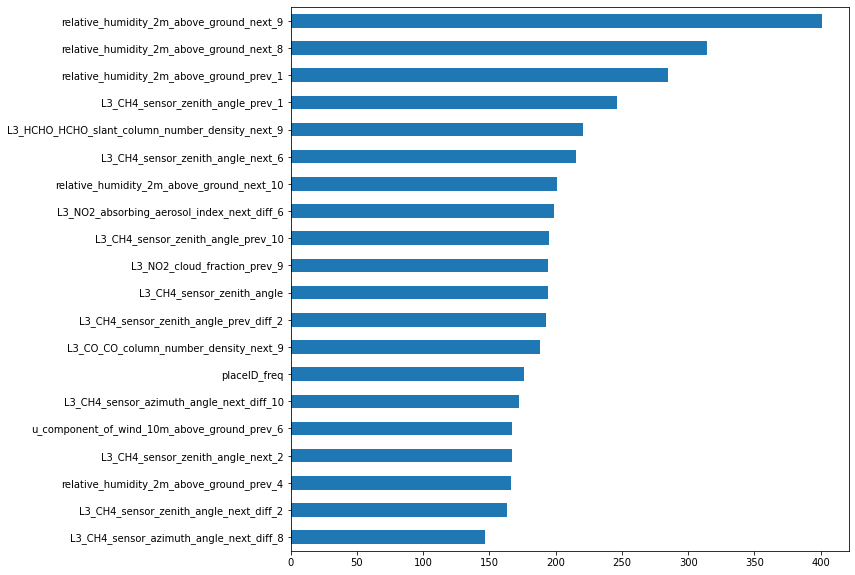

In [16]:
_ = plt.figure(figsize=(10, 10))
fi = pd.Series(index=features, data=clf.feature_importance())
_ = fi.sort_values()[-20:].plot(kind='barh')

In [17]:
rmse(target.values, oofs_df['target'].values)

27.694513458631768

In [18]:
predictions_test = preds_df['target']
predictions_test[predictions_test < 0] = 0

In [19]:
SUB_FILE_NAME = 'preds_lgbm_v1.csv'
sub_df = pd.DataFrame()
sub_df[ID_COL] = test[ID_COL]
sub_df[TARGET_COL] = predictions_test
sub_df.to_csv(SUB_FILE_NAME, index=False)
sub_df.head(10)

,Place_ID X Date,target
0,0OS9LVX X 2020-01-02,32.871844
1,0OS9LVX X 2020-01-03,31.722997
2,0OS9LVX X 2020-01-04,30.805605
3,0OS9LVX X 2020-01-05,34.755467
4,0OS9LVX X 2020-01-06,73.882796
5,0OS9LVX X 2020-01-07,71.834860
6,0OS9LVX X 2020-01-08,29.864601
7,0OS9LVX X 2020-01-09,28.951543
8,0OS9LVX X 2020-01-10,27.678652
9,0OS9LVX X 2020-01-11,32.890756


In [20]:
sub_df[TARGET_COL].describe()

count    16136.000000
mean        57.959790
std         35.554207
min          3.332057
25%         31.492984
50%         48.489986
75%         75.117649
max        275.325099
Name: target, dtype: float64